# Plot the results from CaImAn 3d video segmentation


In [54]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
import pickle
import sys
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

import plotly.graph_objects as go
import plotly.express as px


import caiman_assess_segs_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

Loading BokehJS ...

In [55]:
sys.path.insert(0, '../')
from experiment_info import samples, data_dir, puffs, params
import skimage as ski

# specify the odor file used for the segmentation results you want to analyze
odor_file = f'odor_subset_lists/5_aldehydes_with_refs.txt'
with open(odor_file, 'r') as f:
    odors_to_select = [line.strip() for line in f.readlines() if line != '\n']
puffs_filt = [p for p in puffs if p.odor_name in odors_to_select and p.trial == 1]
print(f'Length of puffs_filt: {len(puffs_filt)}')
# specify the parameters of the segmentation run to analyze
gSig = "4_4_1"
K = 8

# make sure the results dir corresponds with the odor file and parameters
results_dir = f'results/caiman/odor_subset_5_aldehydes/gSig_{gSig}/K{K}'
assert os.path.exists(results_dir), f'{results_dir} does not exist'


Length of puffs_filt: 29


# Load CaImAn results

In [56]:
from dataclasses import dataclass
from collections import defaultdict

@dataclass(slots=True)
class CaimanResults:

    name: str   # name of the sample
    subspecies : str # subspecies of the sample
    A: np.ndarray  # matrix of spatial location of segments; rows are pixels (nonzero values specify the location of the segment), columns are segments 
    C: np.ndarray  # matrix of temporal activity, rows are segments, columns are frames

    # the following attributes, initialized here, are computed using the A and C matrices
    mean_activity: dict = None # the mean pixel intensity for each segment (keys), over time
    maxs_per_odor: defaultdict(list) = None 

    mean_activity_paraffin_subtracted: dict = None # same as mean_activity except the signal of the paraffin odor has been subtracted
    maxs_per_odor_paraffin_subtracted: defaultdict(list) = None # same as maxs_per_odor except the signal of the paraffin odor has been subtracted

## Load in the results from CaImAn: the `A` and `C` matrices

In [57]:
results = []

for samp_name in samples:
    try:
        with open(f'{results_dir}/{samp_name}_cnm2.pkl', 'rb') as f:
            cnm = pickle.load(f)
    except FileNotFoundError:
        print(f'No file found for sample {samp_name}')
        continue

    A = cnm.estimates.A.toarray()
    C = cnm.estimates.C

    subspecies = samp_name.split('_')[1]
    r = CaimanResults(samp_name, subspecies, A, C)

    results.append( r )

for r in results:
    print(f'{r.name}: A {r.A.shape}, C {r.C.shape}')

230913_ORL_GCaMP6f_F1: A (393216, 6), C (6, 3248)
230913_ORL_GCaMP6f_F2: A (393216, 8), C (8, 3248)
230914_ORL_GCaMP6f_F1: A (393216, 7), C (7, 3248)
230914_ORL_GCaMP6f_F2: A (393216, 6), C (6, 3248)
230915_ORL_GCaMP6f_F1: A (393216, 2), C (2, 3248)
230913_U52_GCaMP6f_F2: A (393216, 5), C (5, 3248)
230913_U52_GCaMP6f_F3: A (393216, 7), C (7, 3248)
230914_U52_GCaMP6f_F1: A (393216, 4), C (4, 3248)
230914_U52_GCaMP6f_F2: A (393216, 7), C (7, 3248)
230915_U52_GCaMP6f_F2: A (393216, 7), C (7, 3248)
230913_FCV_GCaMP6f_F1: A (393216, 8), C (8, 3248)
230914_FCV_GCaMP6f_F1: A (393216, 5), C (5, 3248)
230914_FCV_GCaMP6f_F2: A (393216, 6), C (6, 3248)
230914_FCV_GCaMP6f_F3: A (393216, 8), C (8, 3248)
230915_FCV_GCaMP6f_F1: A (393216, 8), C (8, 3248)


In [58]:
import utils.activity_traces as activity_traces

def compute_mean_activity_from_A_C_mats(A, C):
    trace_mean_recontructed = {}
    # go through each segment which are rows of the C matrix
    for seg in range(C.shape[0]):
        # nonzero elements indicate segment location
        seg_indices = np.nonzero(A[:,seg])
        trace_mean_recontructed[seg] = np.array([np.mean(A[:,seg][seg_indices]) * C[seg,i] for i in range(C.shape[1])])
    return trace_mean_recontructed

def subtract_paraffin_response(mean_activity, puffs, params):
    # THIS FUNCTION IS A DUPLICATE OF ONE FOUND IN ACTIVITY TRACE; REDONE HERE BECAUSE CURRENT FUNCTION REQUIRES 2 PARAFFIN PUFFS
    # OPTIONS: 1.) FIT CAIMAN ON BOTH TRIALS AND USE EXISTING FUNCTION 2.) REORGANIZE CODE TO ACCOMODATE 1 PARAFFIN PUFF
    n_frames_to_analyze = params['n_frames_to_analyze']
    num_odors = len(puffs)

    # find indices of the odors delivered that correspond to paraffin, should be 2 for 2 trials
    # NOTE: using index here instead of puff.number as before because you've subselected odors
    paraffin_index = [i for i in range(len(puffs)) if puffs[i].odor_name == "paraffin"]
    assert len(paraffin_index) == 1
    paraffin_index = paraffin_index[0]

    new_traces = []
    # collect paraffin traces for this sample, for both trials; in paraffin_traces dict, keys are trials
    paraffin_trace = mean_activity[paraffin_index*n_frames_to_analyze : (paraffin_index+1)*n_frames_to_analyze]
    
    # subtract paraffin traces from each odor trace
    # NOTE: using index here instead of puff.number as before because you've subselected odors
    for i,puff in enumerate(puffs):
        # i = puff.number
        interval = mean_activity[i*n_frames_to_analyze:(i+1)*n_frames_to_analyze]
        # if this odor was delivered in the first half, subtract paraffin trace from first trial
        interval_subtracted = interval - paraffin_trace
        new_traces.extend(interval_subtracted)
    mean_activity_paraffin_subtracted = np.array(new_traces)
    return mean_activity_paraffin_subtracted



for res in results:
    # compute the mean activity per segment
    res.mean_activity = compute_mean_activity_from_A_C_mats(res.A, res.C)
    # using the mean activity traces, compute the max per odor
    maxs_per_odor = {}
    for seg in res.mean_activity:
        maxs_per_odor[seg], _ = activity_traces.max_activity_per_odor(res.mean_activity[seg], puffs_filt, params)
    res.maxs_per_odor = maxs_per_odor

    # subtract the paraffin activity
    mean_activity_paraffin_subtracted = {}
    for seg in res.mean_activity:
        mean_activity_paraffin_subtracted[seg] = subtract_paraffin_response(res.mean_activity[seg], puffs_filt, params)
    res.mean_activity_paraffin_subtracted = mean_activity_paraffin_subtracted

    # again compute the max per odor
    maxs_per_odor_paraffin_subtracted = {}
    for seg in res.mean_activity_paraffin_subtracted:
        maxs_per_odor_paraffin_subtracted[seg], _ = activity_traces.max_activity_per_odor(res.mean_activity_paraffin_subtracted[seg], puffs_filt, params)
    res.maxs_per_odor_paraffin_subtracted = maxs_per_odor_paraffin_subtracted



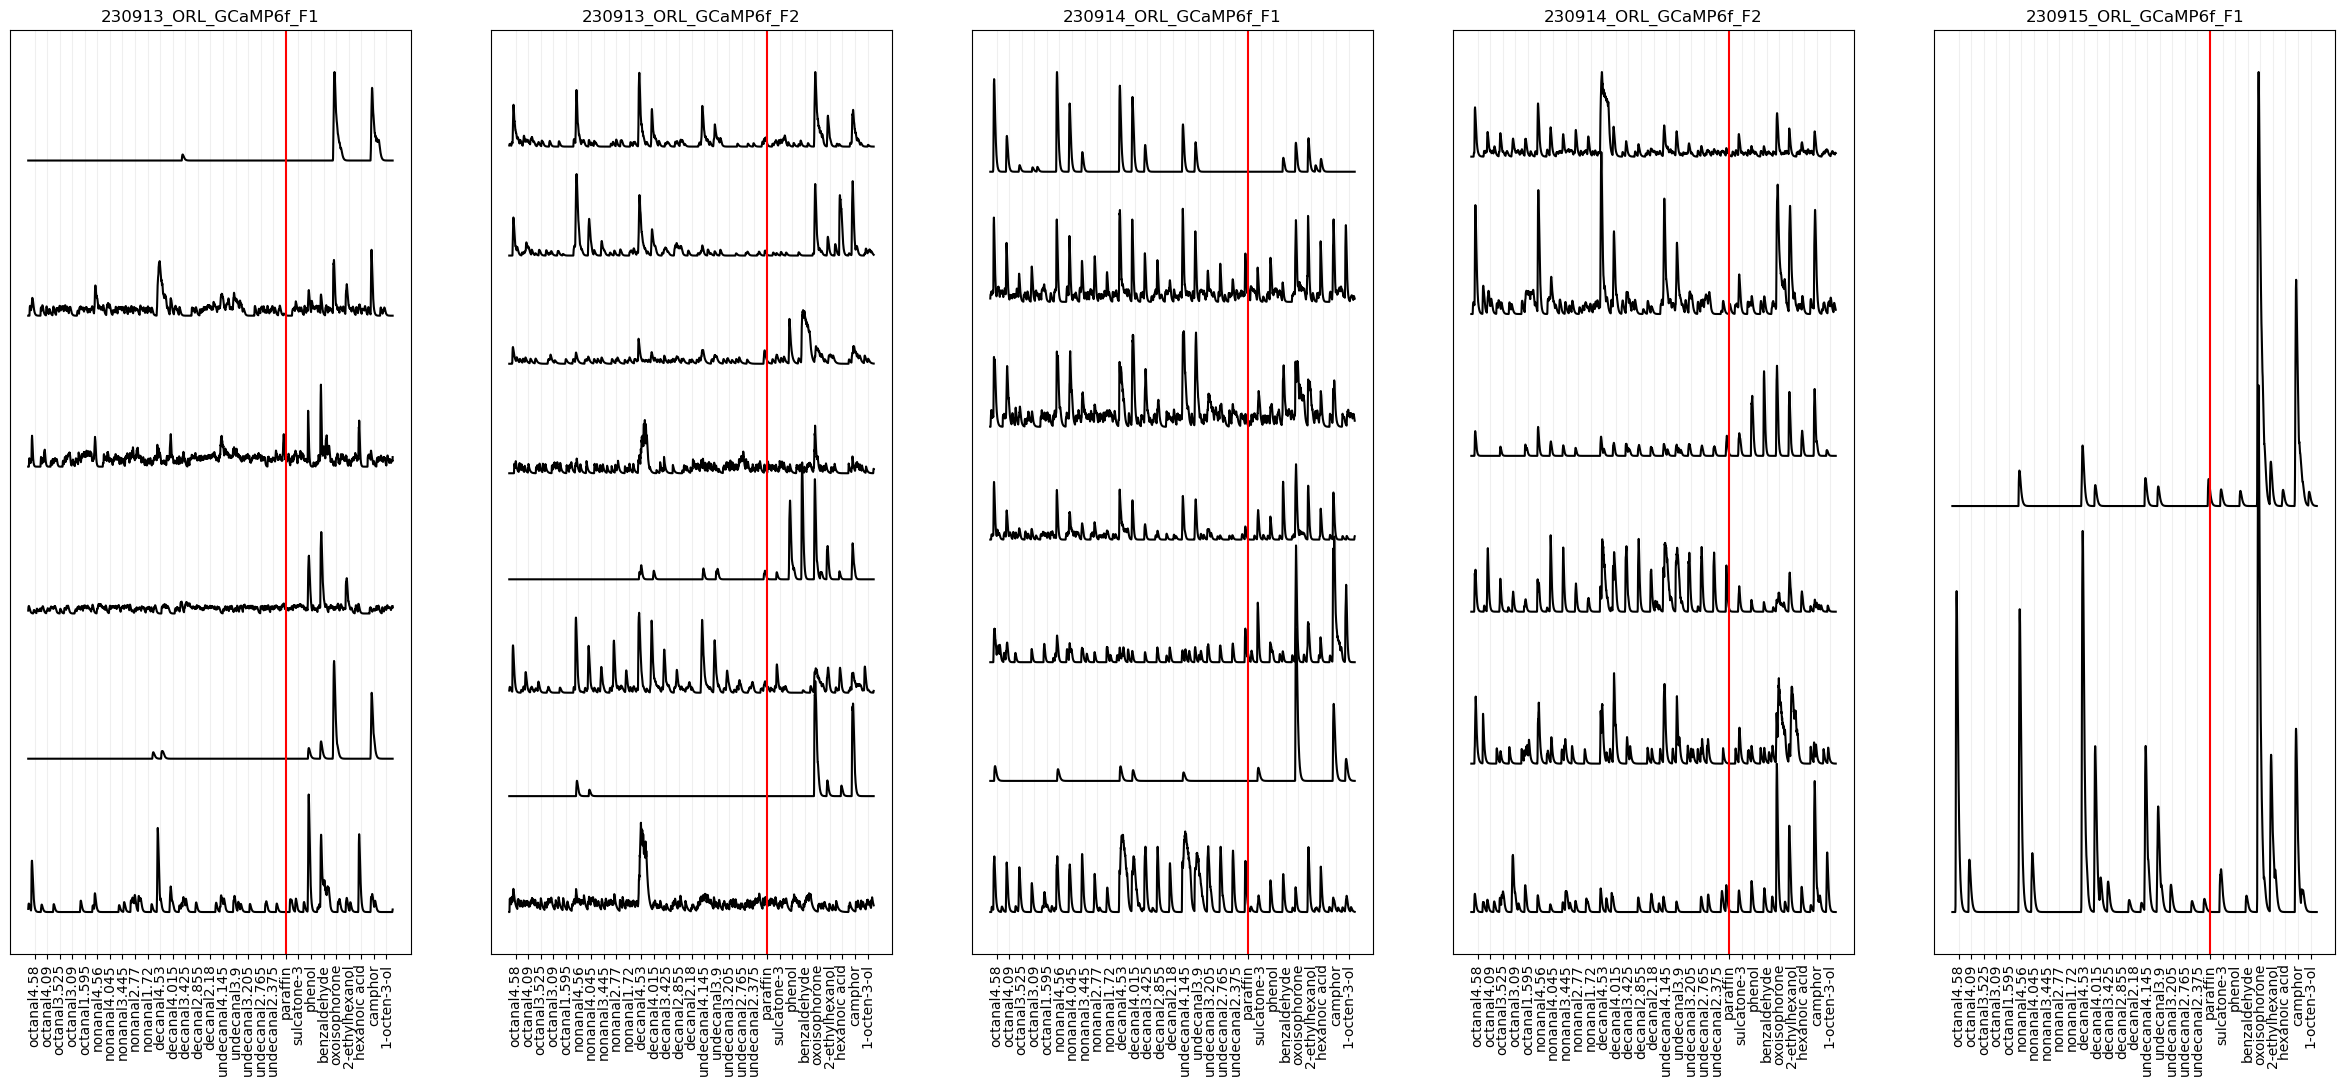

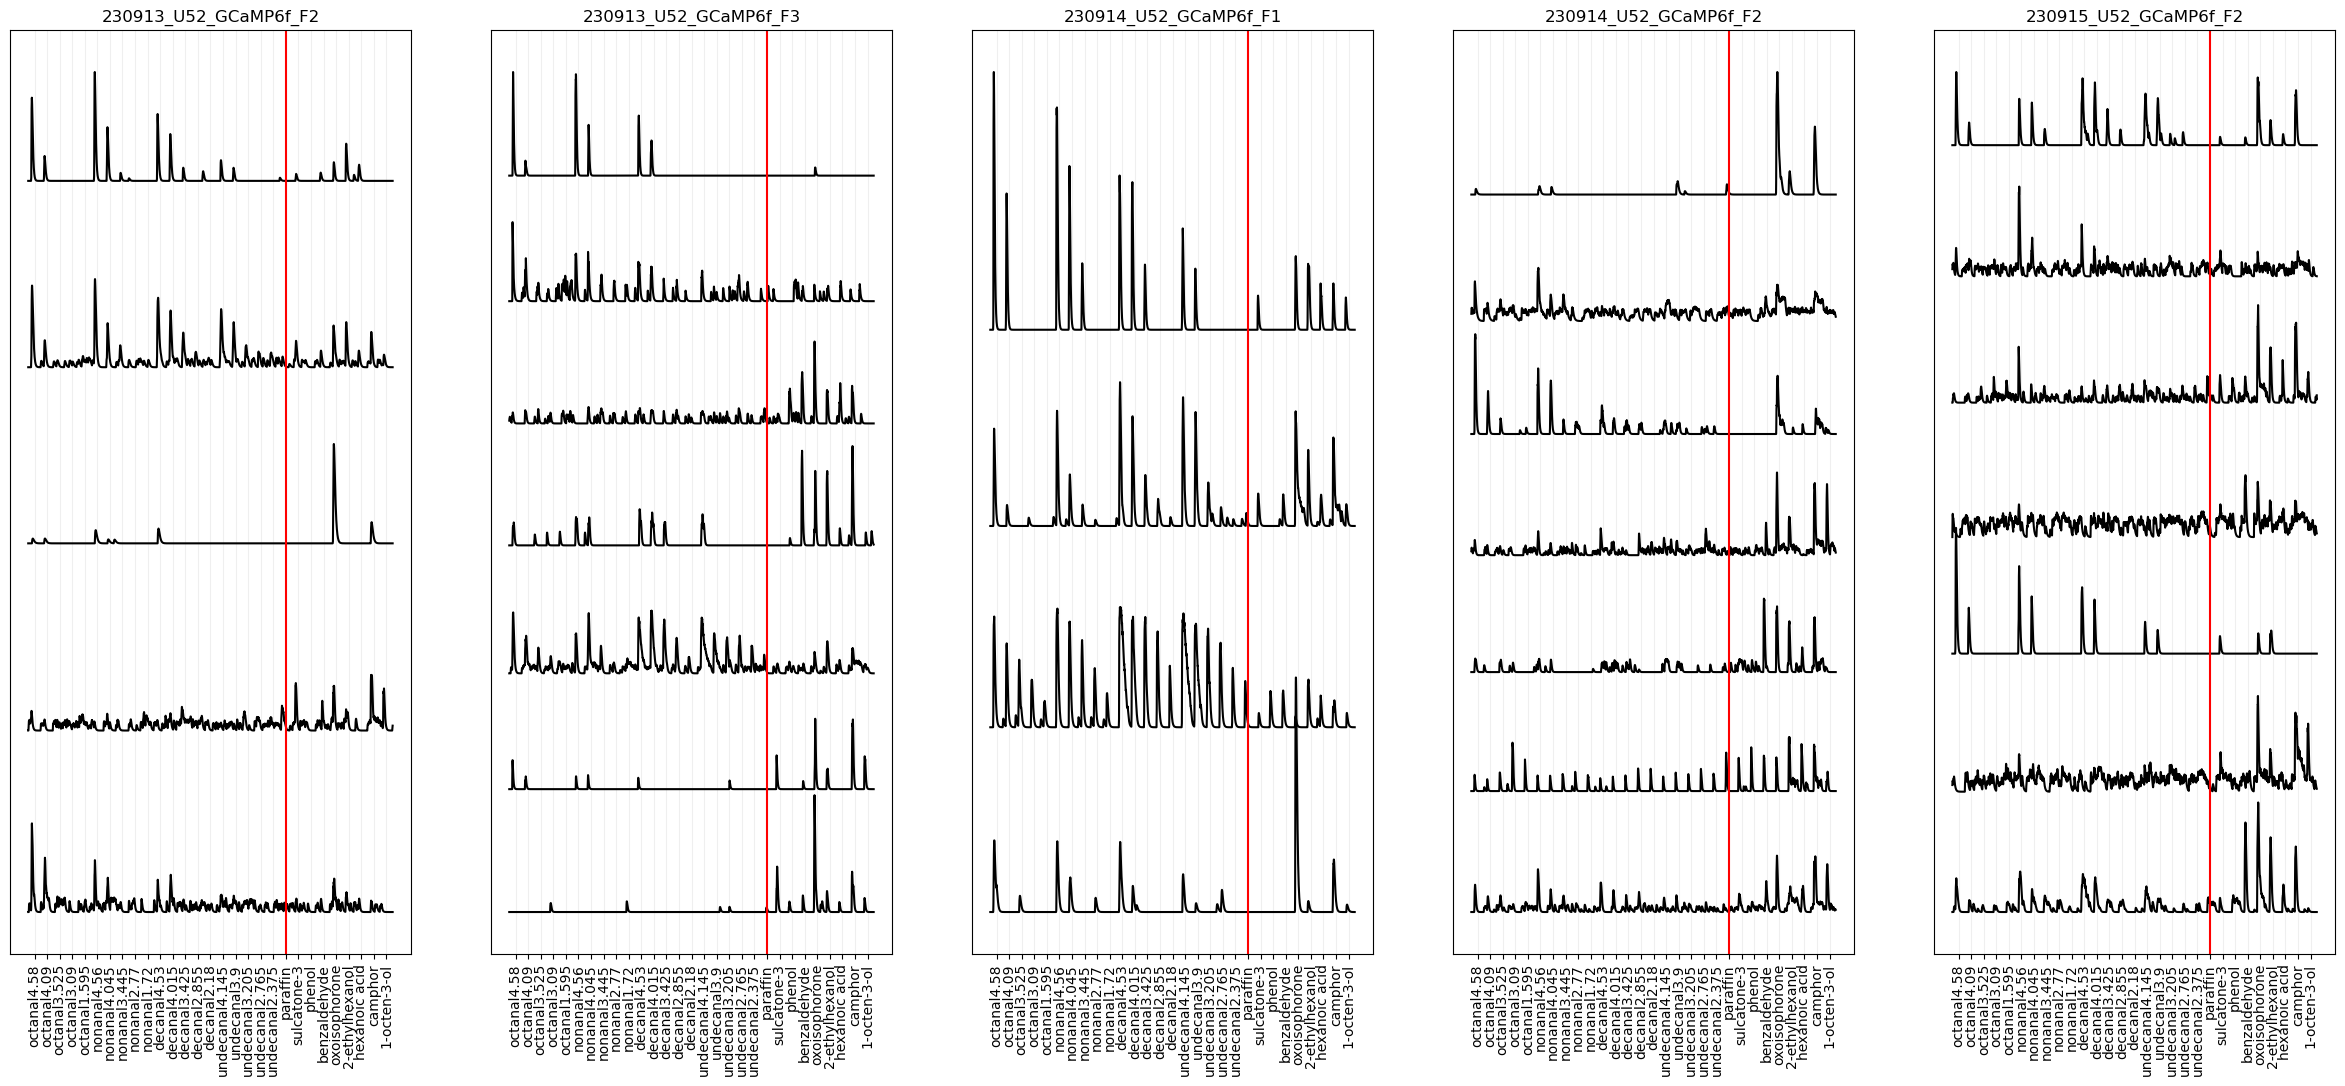

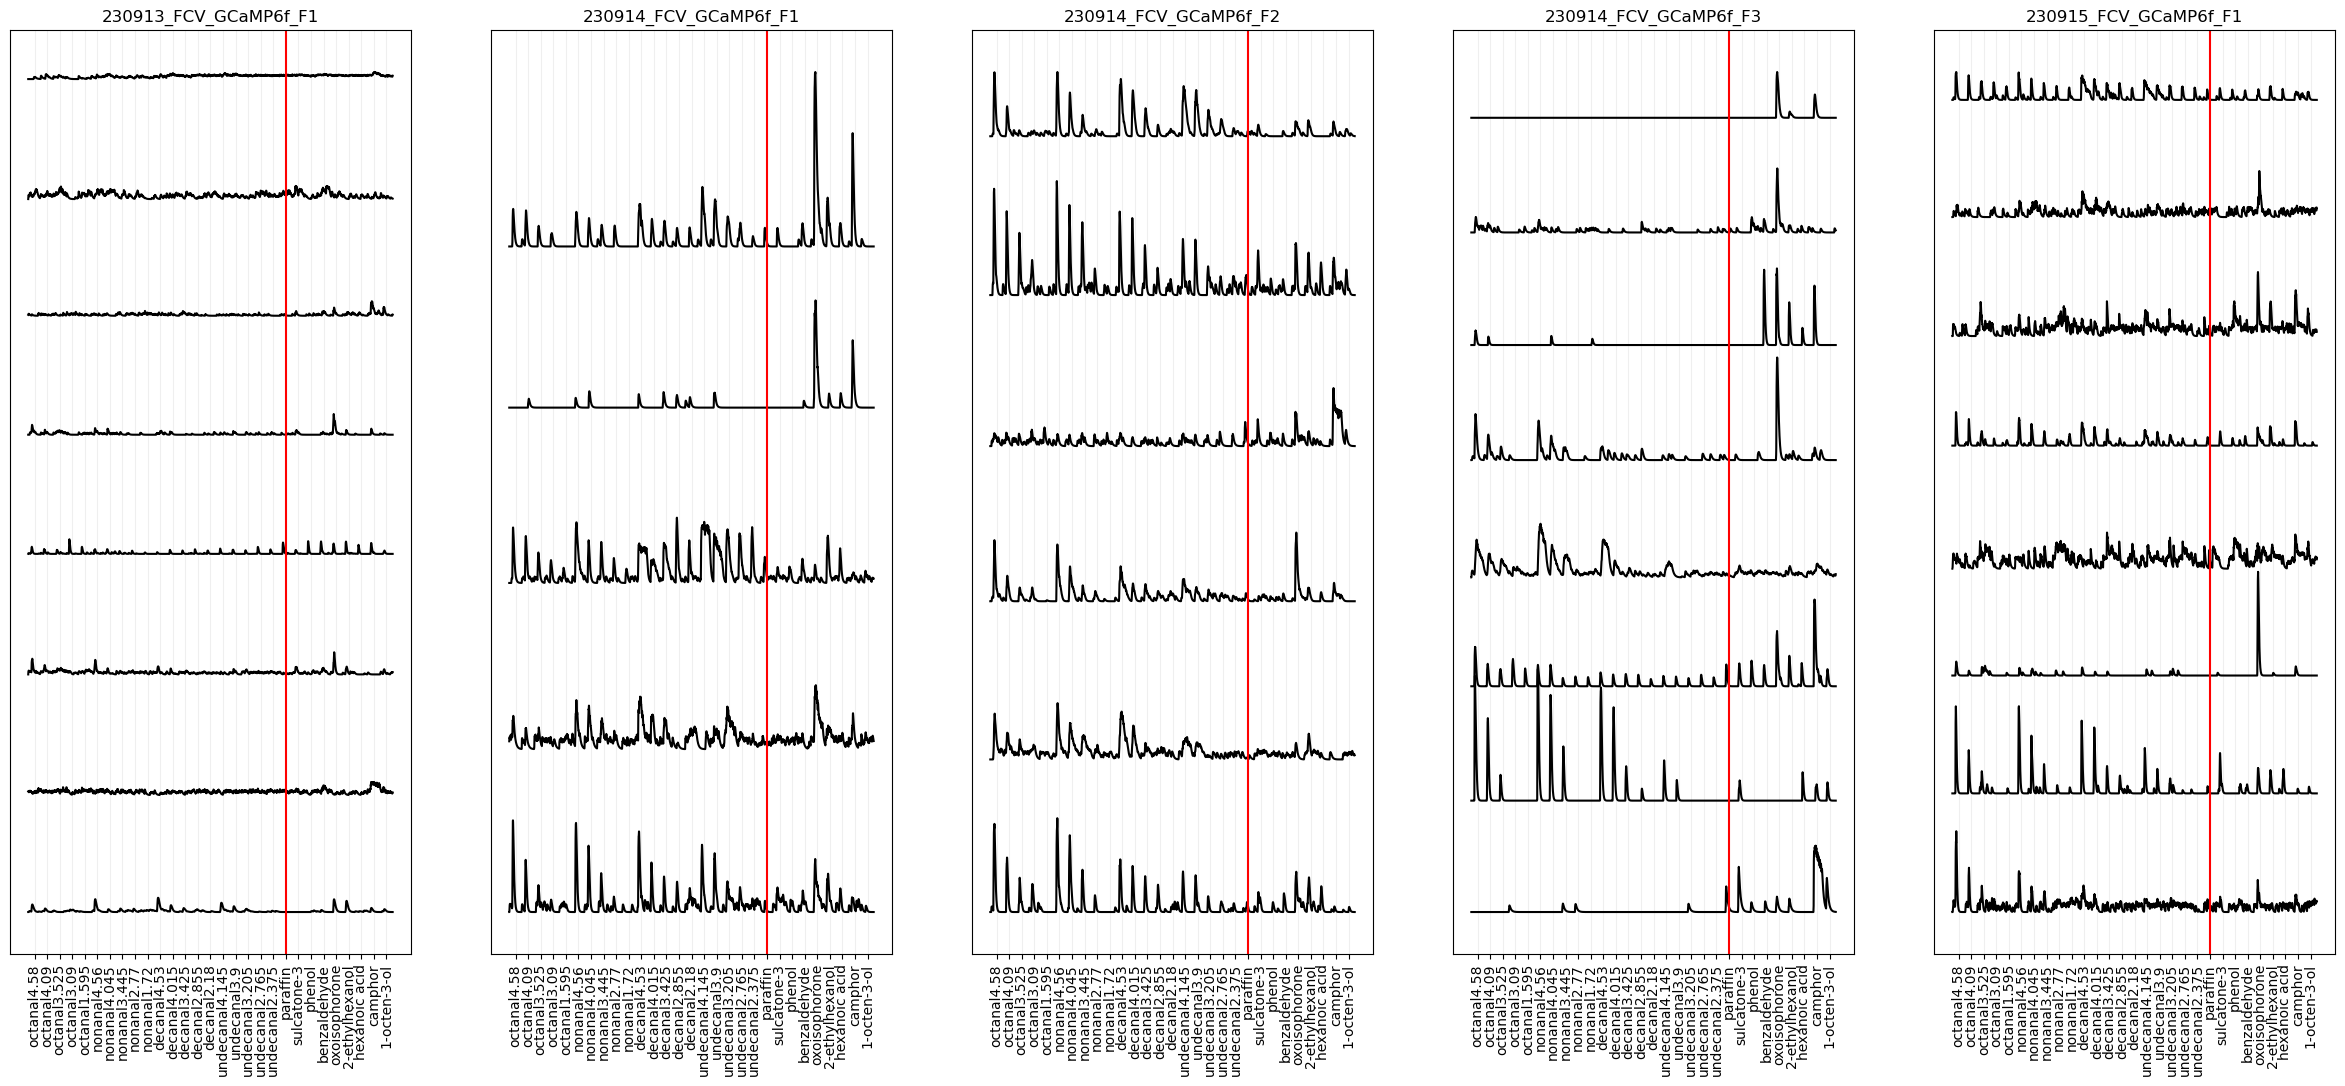

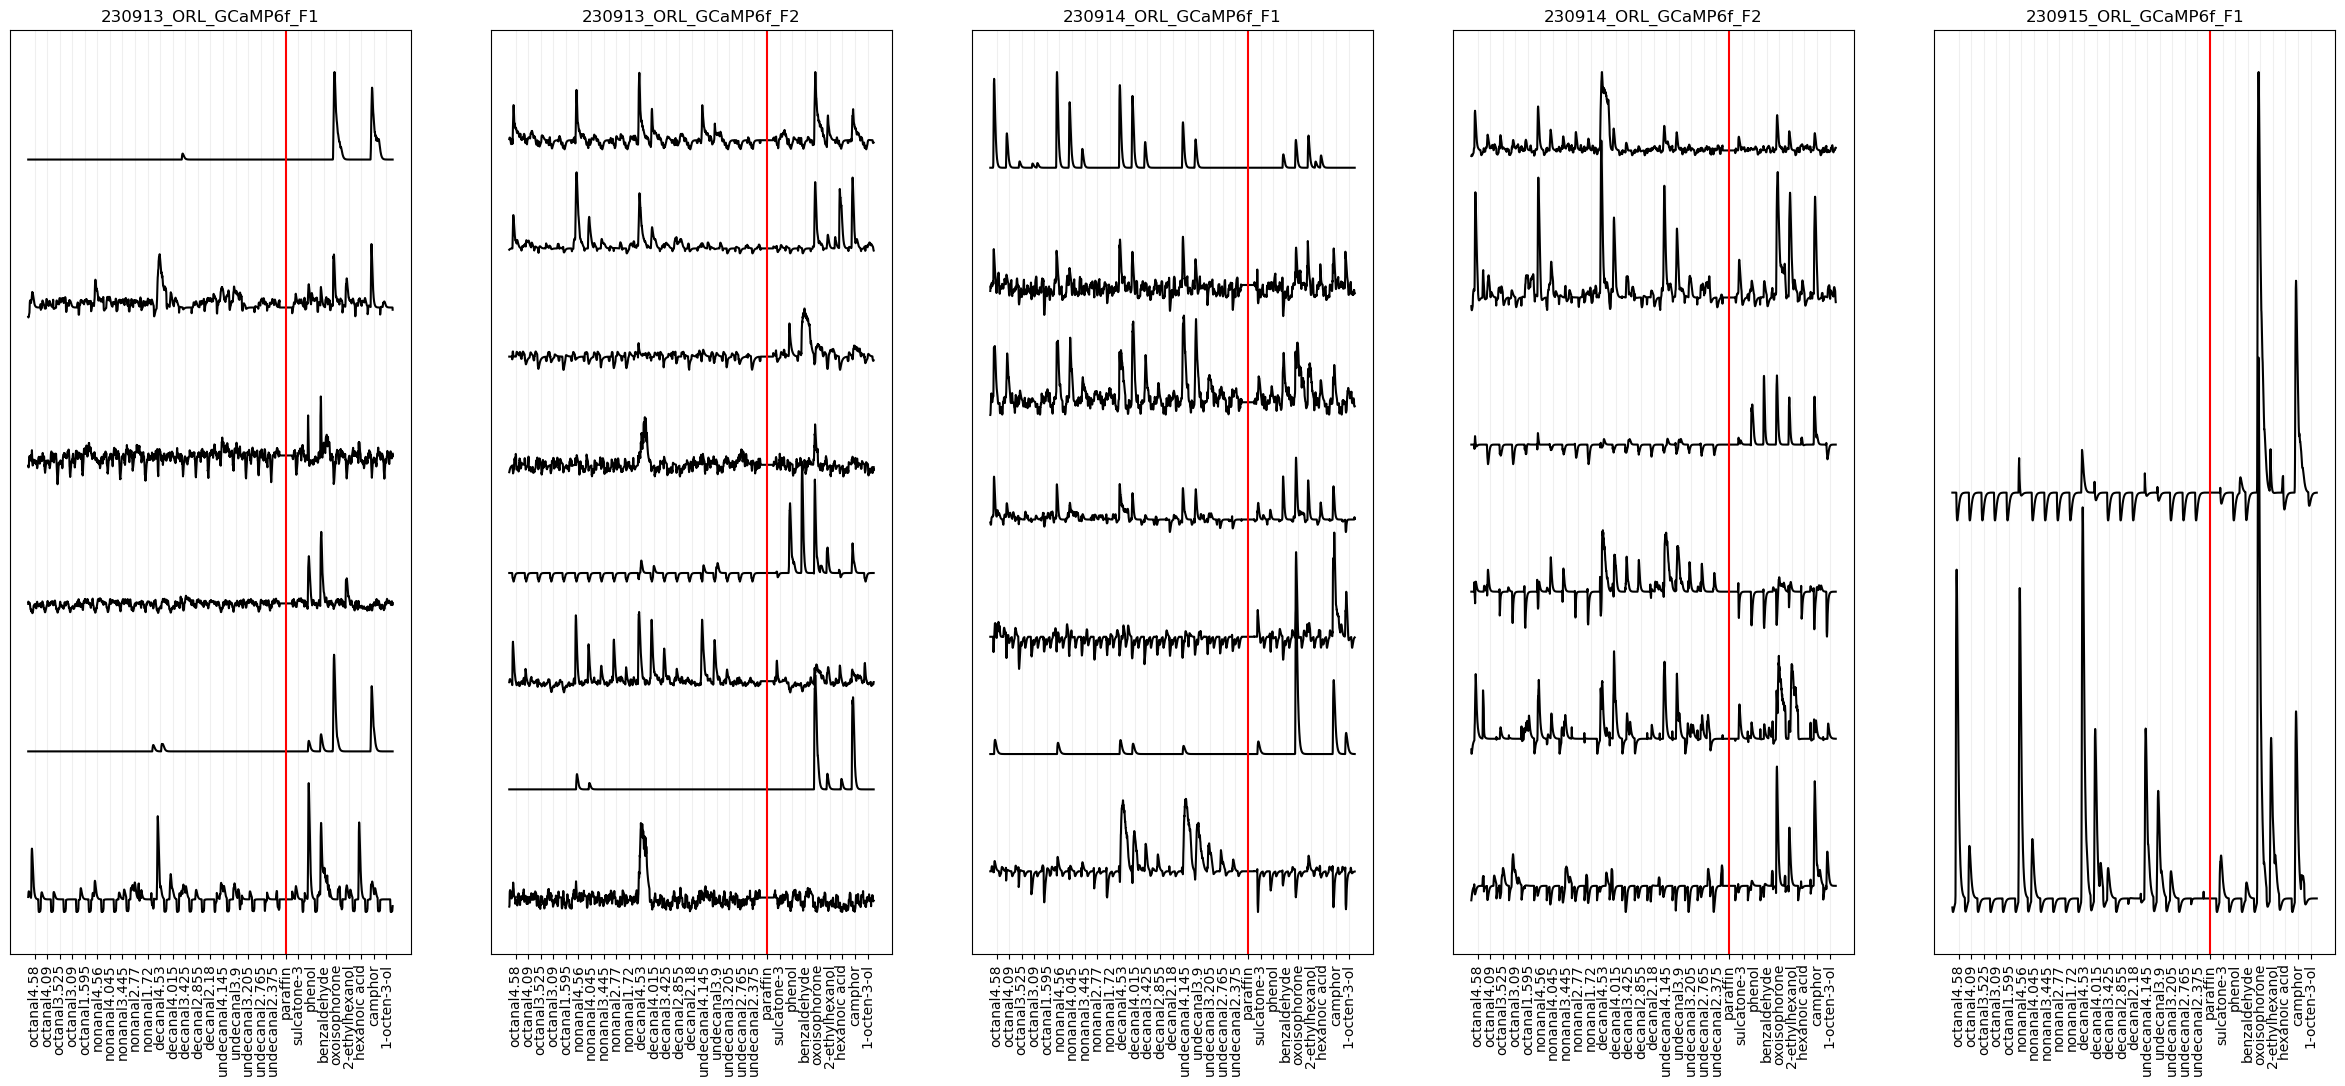

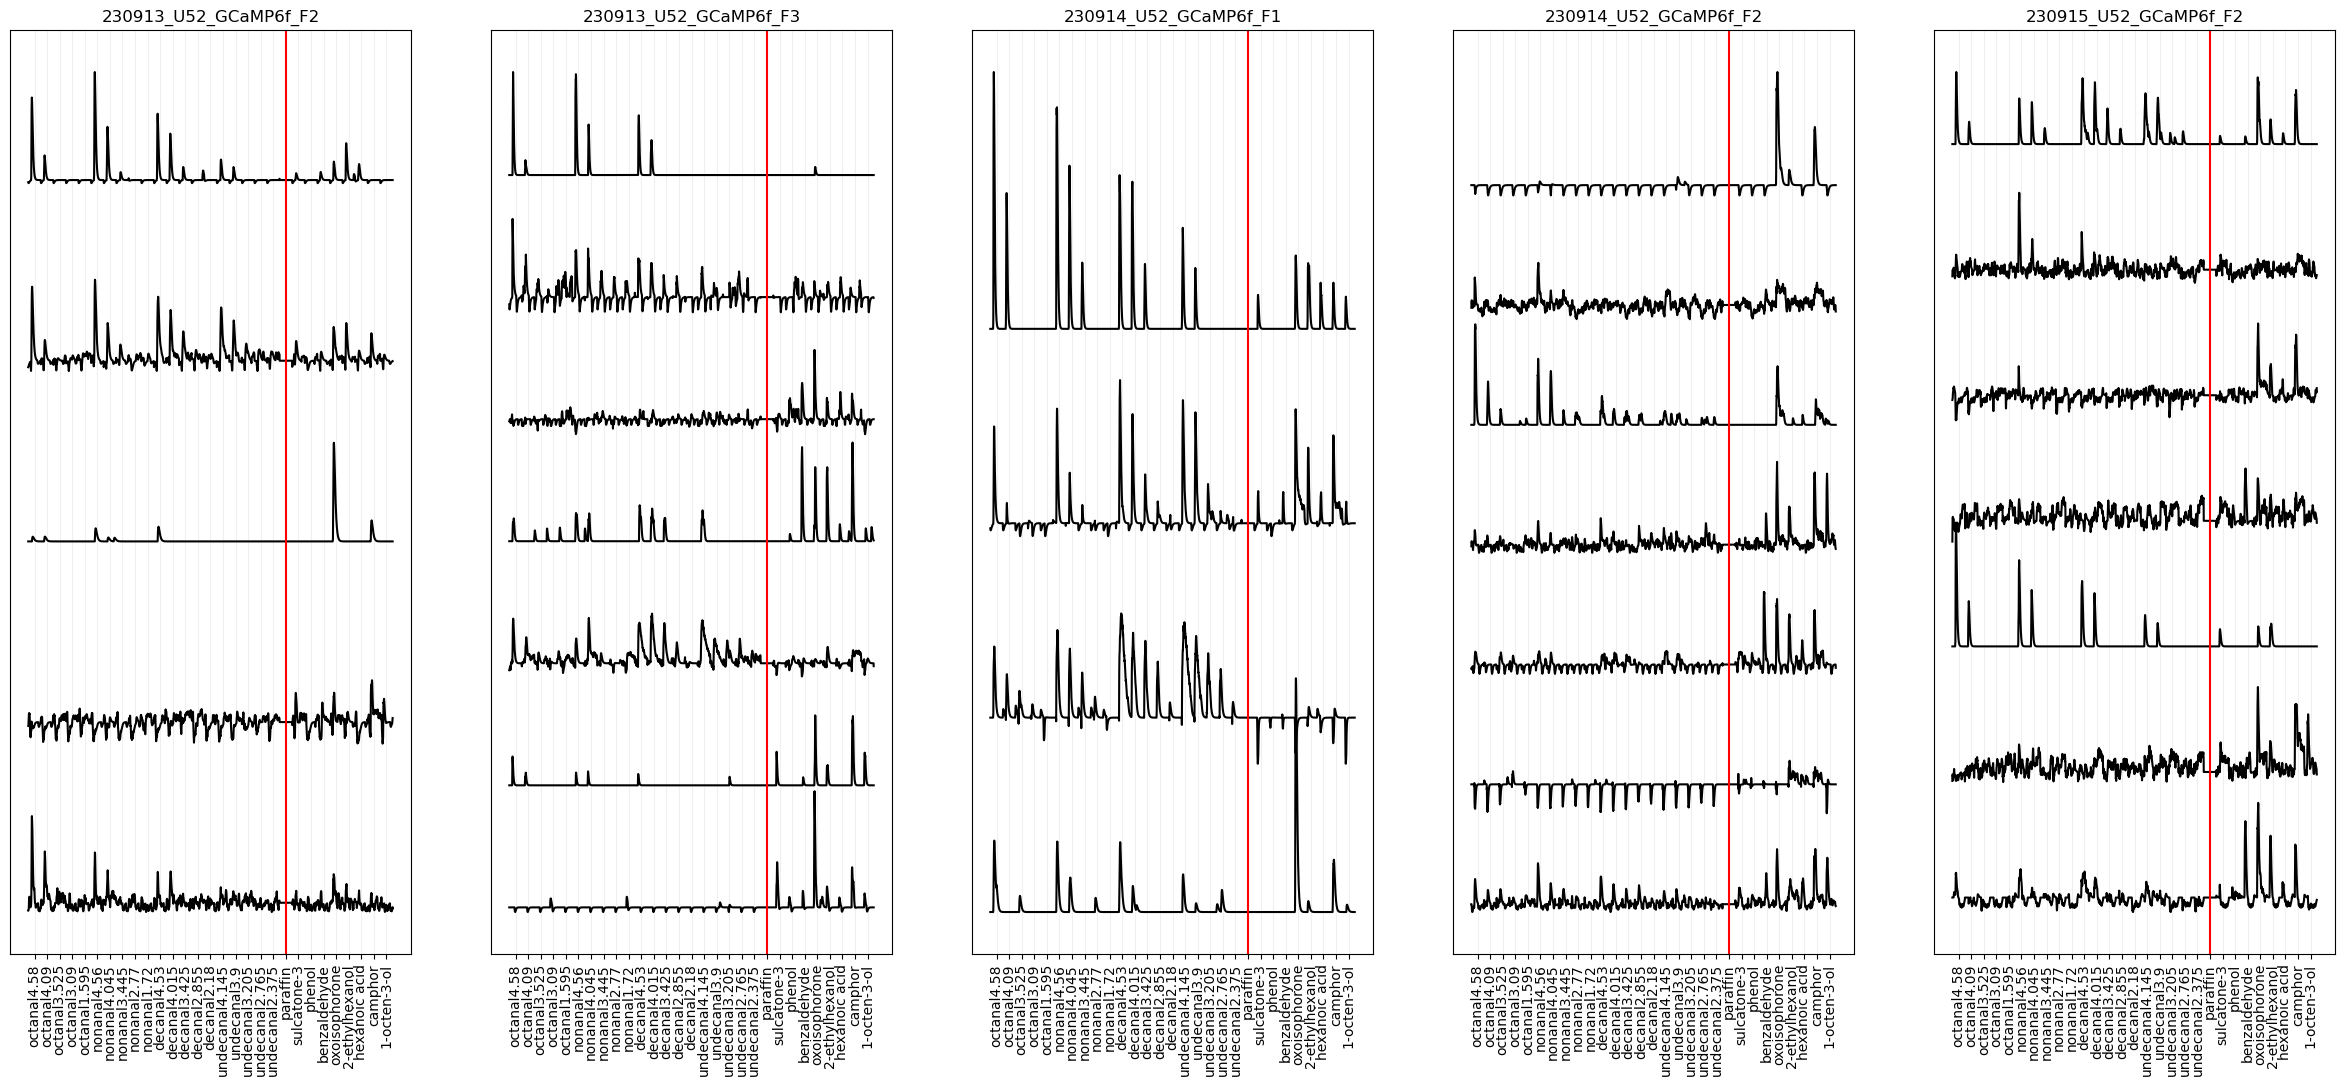

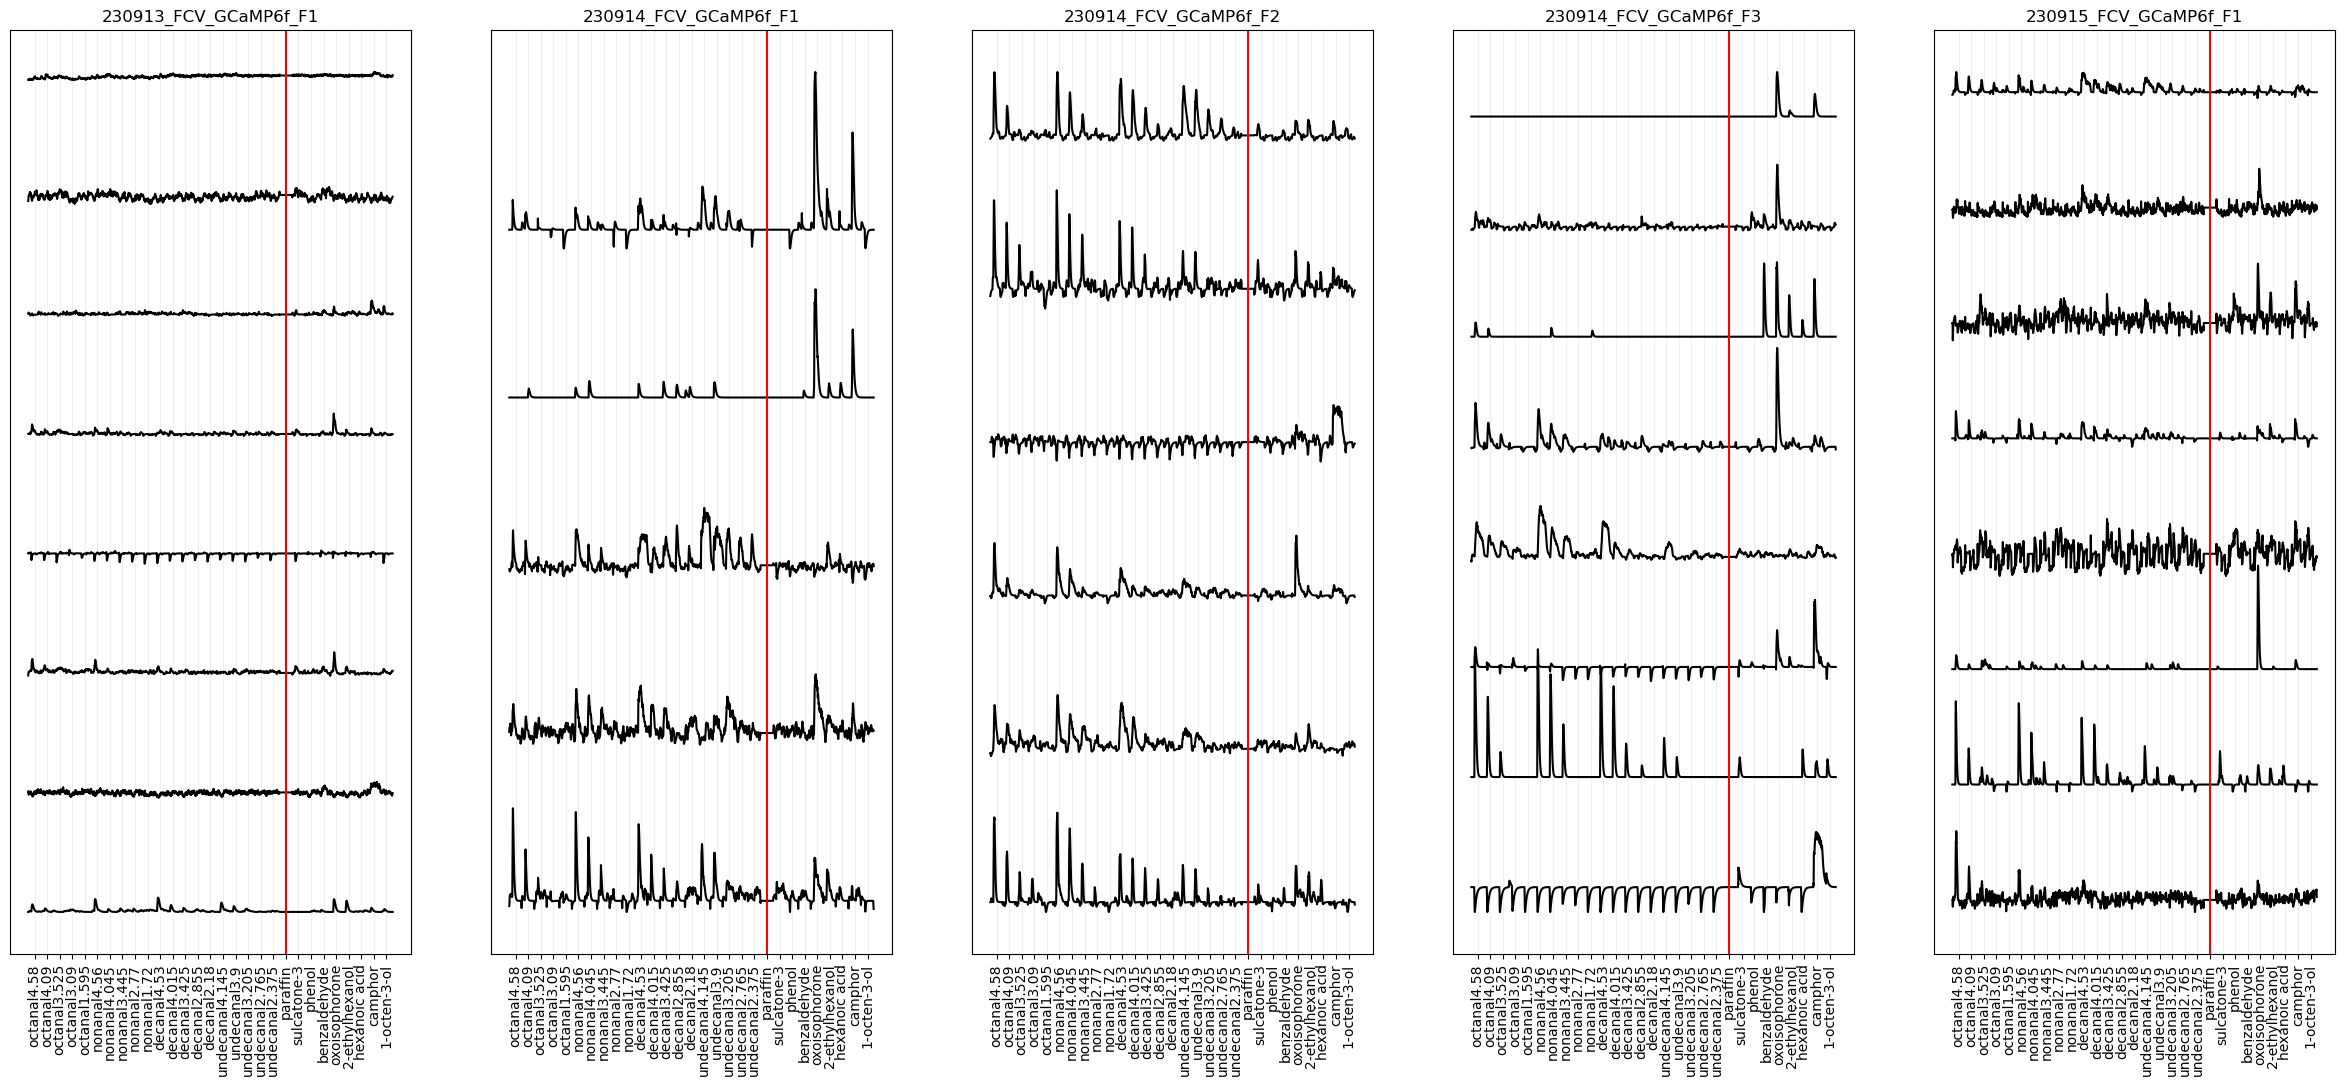

In [73]:
def make_plot_by_subspecies(results, metric, subspecies, odor_names, positions):
    fig, axs = plt.subplots(1,5,figsize=(30, 12))

    results_sub = [r for r in results if r.subspecies == subspecies]

    for i,res in enumerate(results_sub):

        activity = getattr(res, metric)
        # trace_mean_recontructed = compute_mean_activity_from_A_C_mats(res.A, res.C)
        # go through each segment which are rows of the C matrix
        for j, seg in enumerate(activity):
            axs[i].plot(activity[seg] + j*0.02, c='black')
        axs[i].set_yticks([])
        axs[i].set_title(res.name)
        axs[i].set_xticks(positions, odor_names, rotation=90)
        paraffin_index = odor_names.index('paraffin')
        axs[i].axvline(x=positions[paraffin_index], color='r', linestyle='-')  # add grid line
        # add grid line
        axs[i].grid(axis='x', alpha=0.2)

    # save plot
    plt.savefig(f'results/segment_traces_{subspecies}_{metric}.png')
    # plt.show()
    

odor_names = []
positions = []
for i,puff in enumerate(puffs_filt):
    if puff.trial == 1:
        odor_names.append(puff.odor_name)
        positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)

# metric = 'mean_activity'
# metric = 'mean_activity_paraffin_subtracted'

for metric in ['mean_activity', 'mean_activity_paraffin_subtracted']:
    make_plot_by_subspecies(results, metric, "ORL", odor_names, positions)
    make_plot_by_subspecies(results, metric, "U52", odor_names, positions)
    make_plot_by_subspecies(results, metric, "FCV", odor_names, positions)

In [60]:
def convert_to_df(results, puffs, metric):
    df_list = []
    for i,r in enumerate(results):
        df_tmp = pd.DataFrame.from_dict(getattr(r, metric))
        # convert contents of columns from lists to float
        for col in df_tmp.columns:
            df_tmp[col] = df_tmp[col].apply(lambda x: x[0])
        # print(df_tmp.head())
        df_tmp['samp'] = r.name
        df_tmp['subpop'] = r.name.split('_')[1]
        df_tmp['odor'] = df_tmp.index
        df_list.append(df_tmp)
    df = pd.concat(df_list)
    df = df.reset_index(drop=True)
    df = pd.melt(df, id_vars=['samp', 'subpop', 'odor'], var_name='segment', value_name='value')

    return df

peak_max_df = convert_to_df(results, puffs_filt, 'maxs_per_odor')
peak_max_df.to_csv(f'results/peak_max_K{K}_gSig_{gSig}.csv', index=False)

peak_max_df = convert_to_df(results, puffs_filt, 'maxs_per_odor_paraffin_subtracted')
peak_max_df.to_csv(f'results/peak_max_paraffin_subtracted_K{K}_gSig_{gSig}.csv', index=False)




In [61]:
with open(f'results/results.pkl', 'rb') as f:
    pickle.dump(results, f)

samp subpop            odor segment         value
0     230913_ORL_GCaMP6f_F1    ORL     octanal4.58       0  6.862554e-03
1     230913_ORL_GCaMP6f_F1    ORL     octanal4.09       0  9.592423e-04
2     230913_ORL_GCaMP6f_F1    ORL    octanal3.525       0  9.943346e-04
3     230913_ORL_GCaMP6f_F1    ORL     octanal3.09       0 -2.876297e-10
4     230913_ORL_GCaMP6f_F1    ORL    octanal1.595       0  1.514514e-03
...                     ...    ...             ...     ...           ...
3475  230915_FCV_GCaMP6f_F1    FCV   oxoisophorone       7  1.102058e-03
3476  230915_FCV_GCaMP6f_F1    FCV  2-ethylhexanol       7  1.125276e-03
3477  230915_FCV_GCaMP6f_F1    FCV   hexanoic acid       7  3.034254e-04
3478  230915_FCV_GCaMP6f_F1    FCV         camphor       7  1.207735e-03
3479  230915_FCV_GCaMP6f_F1    FCV    1-octen-3-ol       7  4.956788e-04

[3480 rows x 5 columns]

In [62]:
def load_C_A_matrices(results_dir, samples):
    # A matrix specifies the positions of components
    # C matrix specifies the activity of components
    A_mats = []
    C_mats = []
    for i,samp in enumerate(samples):

        try:
            with open(f'{results_dir}/{samp}_cnm2.pkl', 'rb') as f:
                cnm = pickle.load(f)
        except FileNotFoundError:
            print(f'No file found for sample {samp}')
            continue

        A = cnm.estimates.A.toarray()
        C = cnm.estimates.C

        A_mats.append(A)
        C_mats.append(C)
    return A_mats, C_mats

A_mats, C_mats = load_C_A_matrices(results_dir, samples)
print(f'Loaded {len(A_mats)} samples')
print(C_mats[0].shape)
print(A_mats[0].shape)


Loaded 15 samples
(6, 3248)
(393216, 6)


## Split CaImAn results by subspecies

In [63]:
def split_list_by_subspecies(l):
    ORL = l[0:5]
    U52 = l[5:10]
    FCV = l[10:16]
    return ORL, U52, FCV

A_ORL_mats, A_U52_mats, A_FCV_mats = split_list_by_subspecies(A_mats)
C_ORL_mats, C_U52_mats, C_FCV_mats = split_list_by_subspecies(C_mats)
ORL_names, U52_names, FCV_names = split_list_by_subspecies(samples)

print(len(C_ORL_mats), len(C_U52_mats), len(C_FCV_mats))

5 5 5


## Plot activity traces

In [64]:
def make_plot_by_subspecies(C_mats, A_mats, samp_names, odor_names, positions):
    fig, axs = plt.subplots(1,5,figsize=(35, 6))
    for samp,(C,A) in enumerate(zip(C_mats, A_mats)):
        for seg in range(C.shape[0]):
            seg_indices = np.nonzero(A[:,seg])
            trace_mean_recontructed = np.array([np.mean(A[:,seg][seg_indices]) * C[seg,i] for i in range(C.shape[1])])
            # print(np.max(trace_mean_recontructed))
            # plot the trace directly from C matrix
            # axs[samp].plot(C[seg,:] + seg*2, c='black')  # Offset each trace by i*3
            # plot the trace from A and C matrix
            axs[samp].plot(trace_mean_recontructed + seg*0.02, c='black')
        axs[samp].set_yticks([])
        axs[samp].set_title(samp_names[samp])
        axs[samp].set_xticks(positions, odor_names, rotation=90)
        paraffin_index = odor_names.index('paraffin')
        axs[samp].axvline(x=positions[paraffin_index], color='r', linestyle='-')  # add grid line
        # add grid line
        axs[samp].grid(axis='x', alpha=0.2)

odor_names = []
positions = []
for i,puff in enumerate(puffs_filt):
    if puff.trial == 1:
        odor_names.append(puff.odor_name)
        positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
    

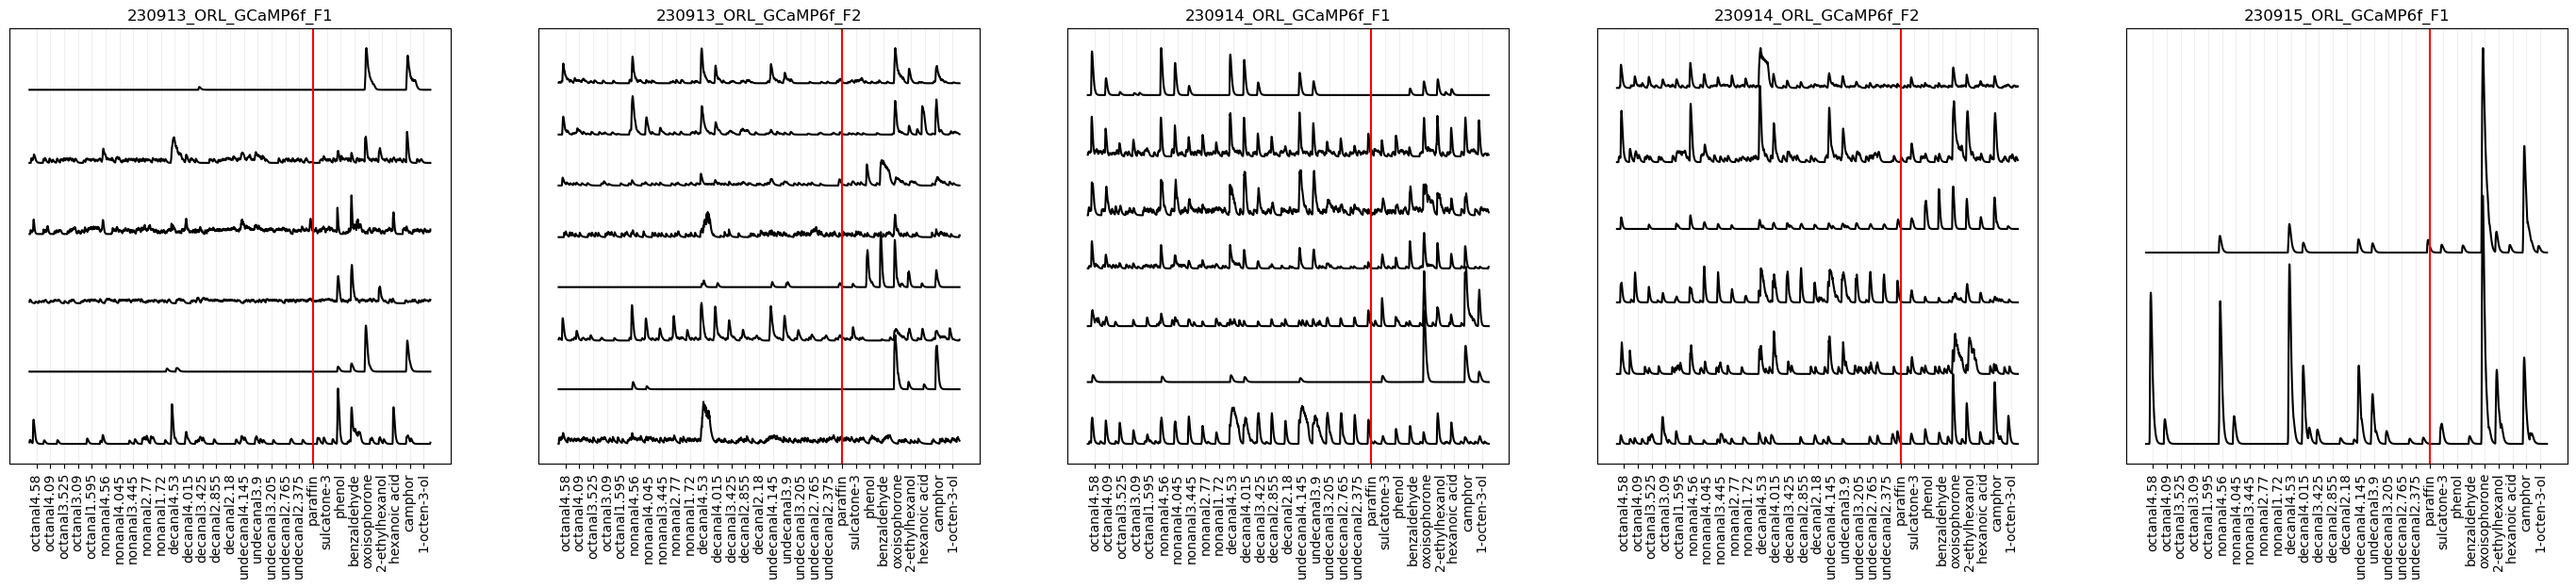

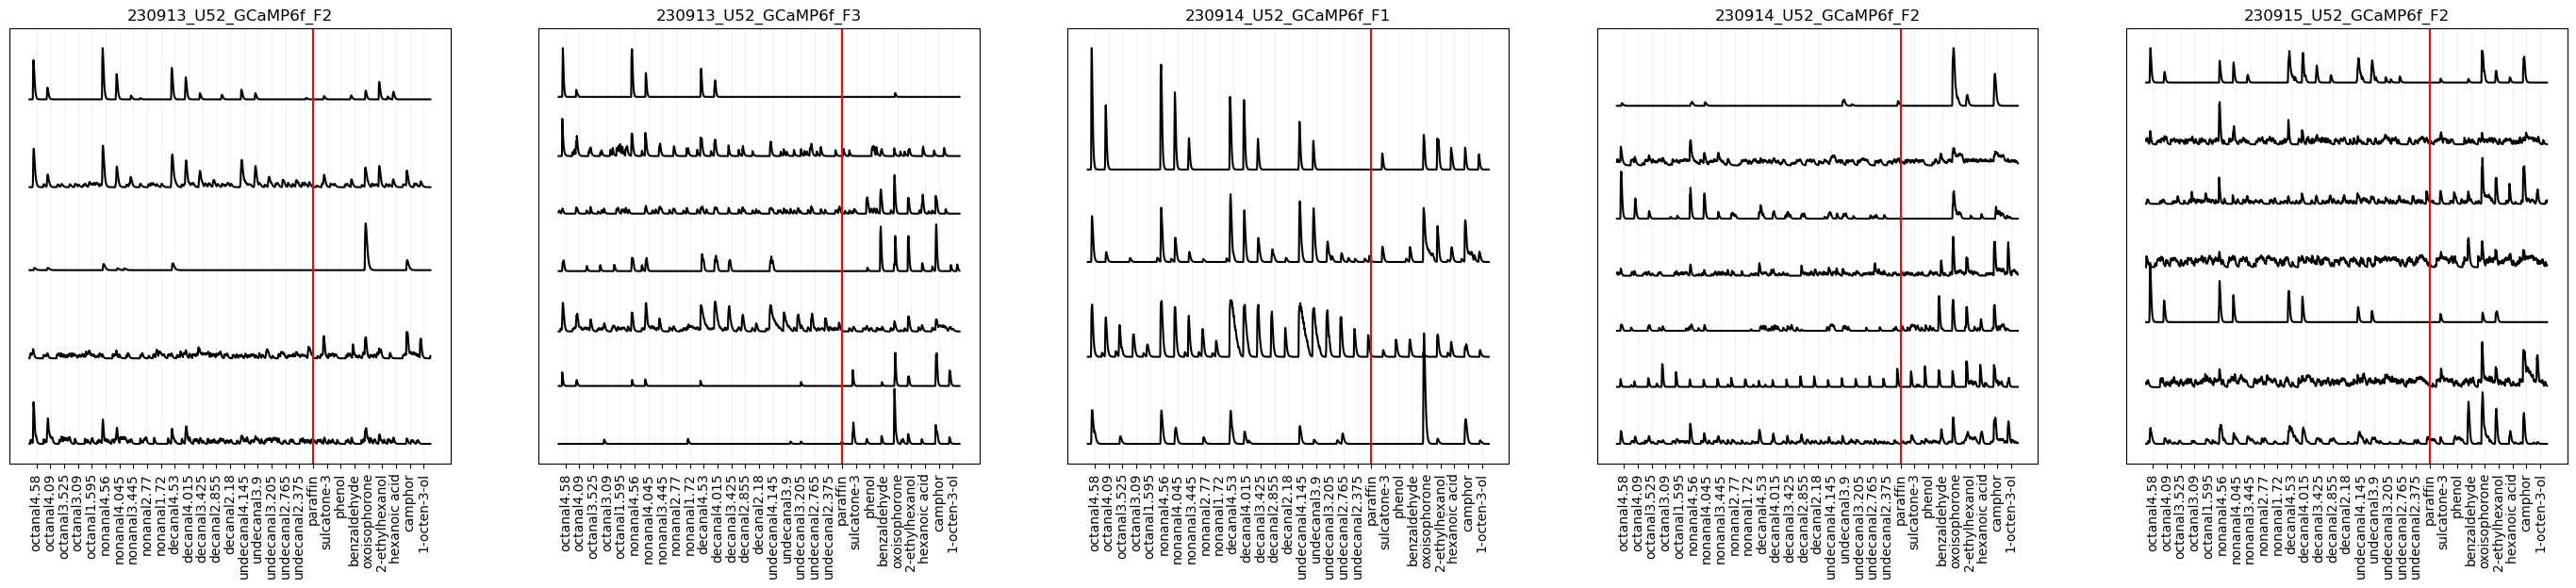

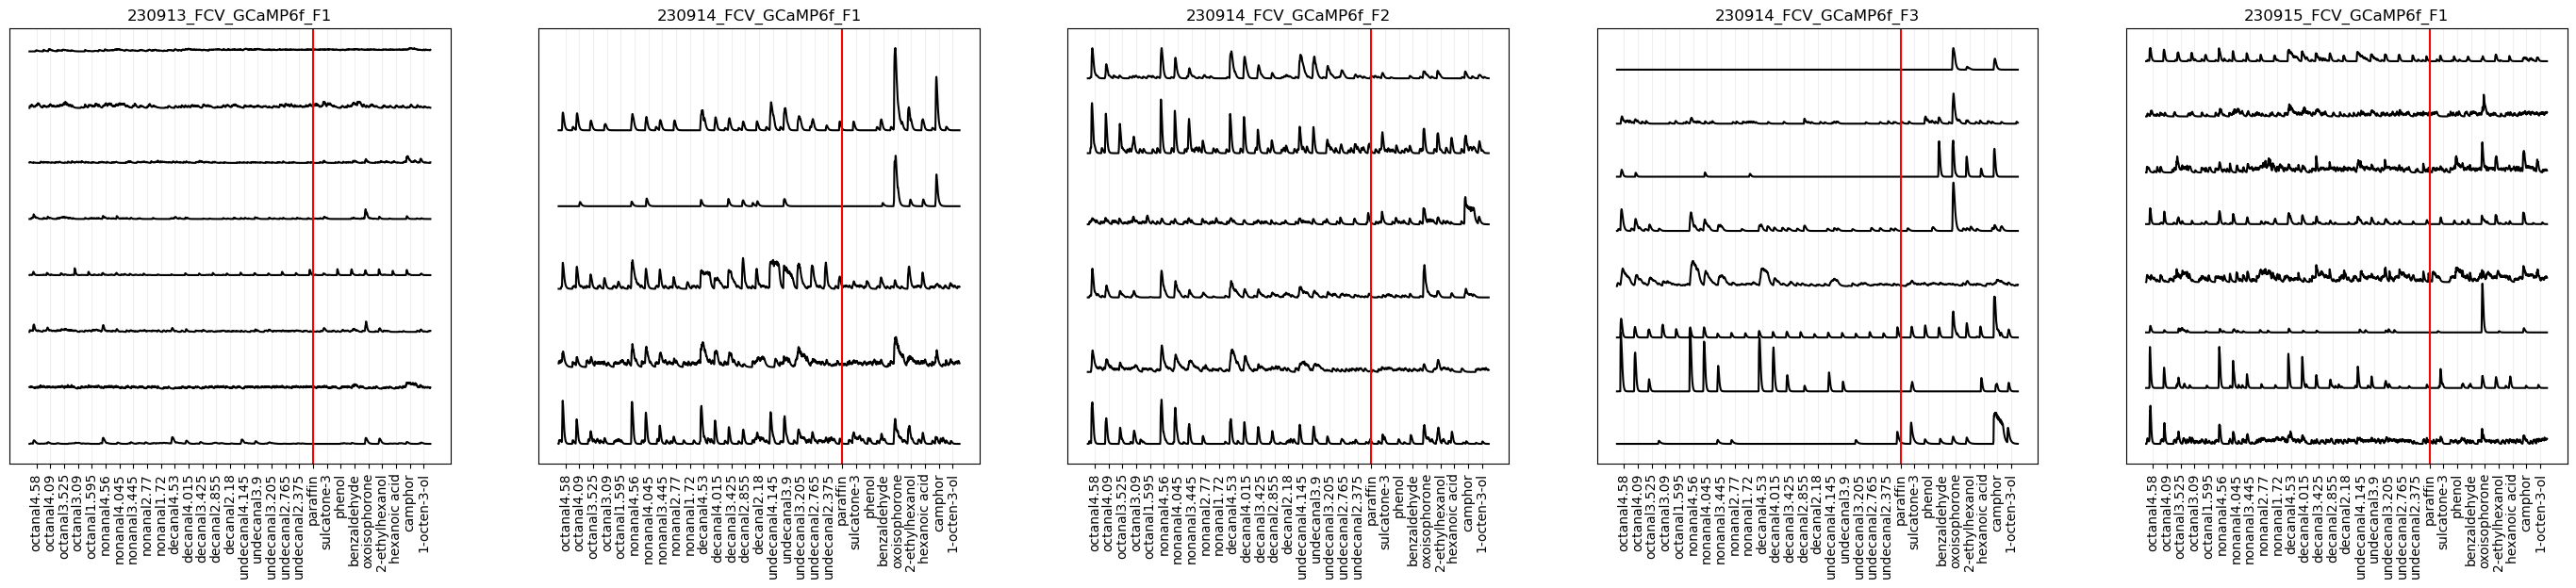

In [65]:
make_plot_by_subspecies(C_ORL_mats, A_ORL_mats, ORL_names, odor_names, positions)
make_plot_by_subspecies(C_U52_mats, A_U52_mats, U52_names, odor_names, positions)
make_plot_by_subspecies(C_FCV_mats, A_FCV_mats, FCV_names, odor_names, positions)

# Compute correlations between segments

In [66]:

def compute_corrs_and_intersections(C_mats, A_mats, names):
    within_samp_seg_corrs = {} # a dictionary of segment-wise correlations, i.e. for each segment, the correlation with all other segments
    intersection_fractions = {} # a dictionary of segment-wise intersection fractions, i.e. for each segment, the fraction of pixels that overlap with all other segments

    for i,samp in enumerate(names):
        corr_mat = fn.calculate_pairwise_temporal_corrs(C_mats[i], C_mats[i])
        # This is the full correlation matrix
        # for each row in corr_mat, get the off-diagonal elements
        # Row indices
        rows = np.arange(corr_mat.shape[0])
        # reshape matrix to not have diagonal elements
        non_diagonal_elements = [corr_mat[j, rows != j] for j in range(corr_mat.shape[0])]
        # take transpose so that columns correpond to total number of segments, and rows are 1 fewer than this number (b/c diagonal removed)
        within_samp_seg_corrs[samp] = np.array(non_diagonal_elements).T

        # repeat for calculating overlaps between segments
        intersection_fractions[samp] = fn.calculate_intersections_per_seg(A_mats[i], params['z_dim'], params['x_dim'], params['y_dim'])

    return within_samp_seg_corrs, intersection_fractions

within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_ORL_mats, A_ORL_mats, ORL_names)
# within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_U52_mats, A_U52_mats, U52_names)    
# within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_FCV_mats, A_FCV_mats, FCV_names)        

/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)
/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_o

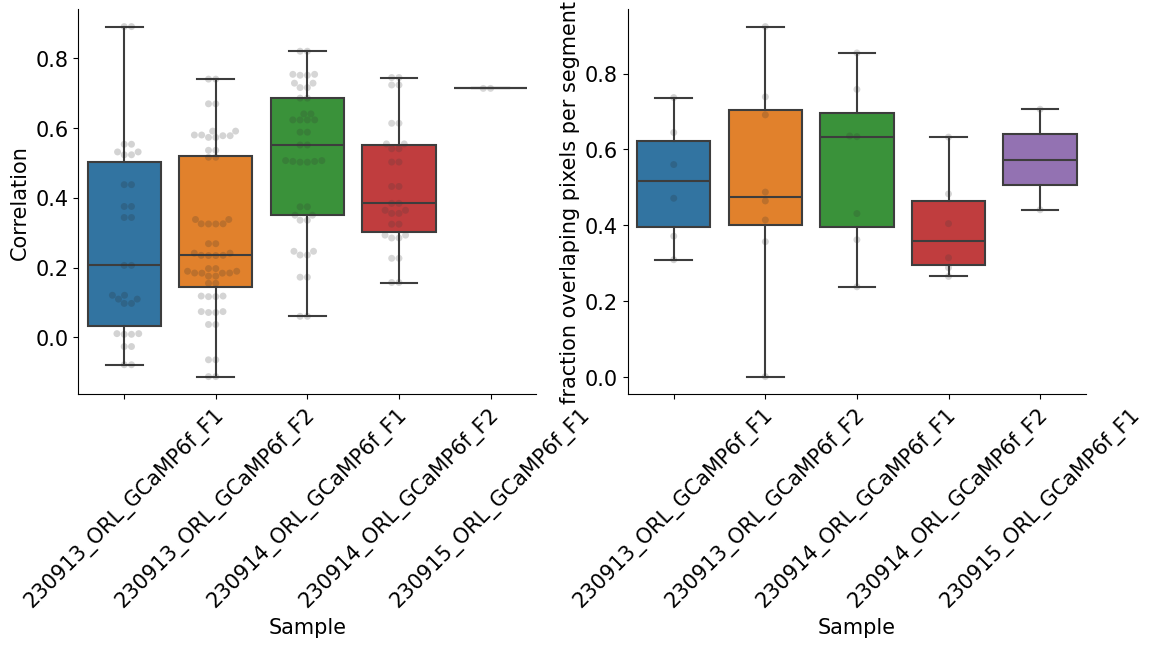

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
aggregated_corrs = {}
for i,s in enumerate(within_samp_seg_corrs):
    # get all pairwise segment correlations within sample
    aggregated_corrs[s]= within_samp_seg_corrs[s].flatten()
    # assert len(aggregated_corrs[s]) == (C_mats[0].shape[0] * (C_mats[0].shape[0] - 1)), "incorrect number of observations"
# Convert each list to a Series and create the DataFrame, using series naturally accounts for missing data (some samples have fewer segments, making diff number of rows per column)
corr_df = pd.DataFrame({k: pd.Series(v) for k, v in aggregated_corrs.items()})
# corr_df = pd.DataFrame.from_dict(aggregated_corrs)
intersection_df = pd.DataFrame({k: pd.Series(v) for k, v in intersection_fractions.items()})

# make a catplot of df showing box plot and the raw observations
sns.boxplot(data=corr_df, ax=axs[0])
sns.swarmplot(data=corr_df, color=".25", alpha=0.2, ax=axs[0])
axs[0].set_xlabel('Sample', fontsize=15)
axs[0].set_ylabel('Correlation', fontsize=15)
# rotate x labels
axs[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=intersection_df, ax=axs[1])
sns.swarmplot(data=intersection_df, color=".25", alpha=0.2, ax=axs[1])
axs[1].set_xlabel('Sample', fontsize=15)
axs[1].set_ylabel('fraction overlaping pixels per segment', fontsize=15)
axs[1].tick_params(axis='x', rotation=45)

# increase font size of x and y labels
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)

sns.despine()

## Make 3D plot of glomeruli for specific individual
Assess how much segments span x,y,z axes

In [68]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly
  
# make copy of array
X = np.copy(A_ORL_mats[3])

# Iterate over datasets, adding each to the figure
for i in range(X.shape[1]): # columns of X are segments

  
  X_tmp = X[:,i]
  thresh = np.quantile(X_tmp[X_tmp>0], 0.75)
  X_tmp[X_tmp < thresh] = 0

  X_tmp = np.reshape(X_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
  z, x, y = np.nonzero(X_tmp)

  # get coordinate of the element with the maximum value
  z_max, x_max, y_max = np.unravel_index(np.argmax(X_tmp, axis=None), X_tmp.shape)
  z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                              mode='markers',
                              marker=dict(size=6, opacity=0.01, color=colors[i]),
                              name=f'Set {i+1}'))  # Name each set for the legend
  fig.add_trace(go.Scatter3d(x=x_max, y=y_max, z=z_max,
                              mode='markers',
                              marker=dict(size=4, opacity=1, color='black'),
                              name=f'Set {i+1}'))  # Name each set for the legend

# Update layout with axis limits and title
fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis', range=[0, 128]),
                    yaxis=dict(title='Y Axis', range=[0, 128]),
                    zaxis=dict(title='Z Axis', range=[0, 24]),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=1)),  # Adjust z aspect ratio according to the z range),
                  title='Multiple 3D Coordinate Sets',
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# Show the plot
fig.show()

In [69]:
colors = plt.get_cmap('tab10')  # 'tab10' is the default matplotlib colormap
colors = [colors(i/10) for i in range(10)]

colors



[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

In [70]:
def load_h5(filename):
    with h5py.File(filename, 'r') as file:
        dataset = file['data'] # Access the dataset containing the 3D matrix
        mat = np.array(dataset)
    return mat

samp = "230914_ORL_GCaMP6f_F2"
X_file = f'/jukebox/mcbride/bjarnold/new_analysis/data/Mar_22_2024/4_Glomeruli/{samp}/svd_k_20/cluster_power_8/segments_10/X.h5'
X_mat = load_h5(X_file)
fig = go.Figure()

# X = X_mat_ref
X = X_mat

for i in range(X.shape[1]): # columns of X are segments

  
  X_tmp = X[:,i]
  thresh = np.quantile(X_tmp[X_tmp>0], 0.0)
  X_tmp[X_tmp < thresh] = 0

  X_tmp = np.reshape(X_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
  z, x, y = np.nonzero(X_tmp)

  # get coordinate of the element with the maximum value
  z_max, x_max, y_max = np.unravel_index(np.argmax(X_tmp, axis=None), X_tmp.shape)
  z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                              mode='markers',
                              marker=dict(size=2, opacity=0.05),
                              name=f'Set {i+1}'))  # Name each set for the legend
  fig.add_trace(go.Scatter3d(x=x_max, y=y_max, z=z_max,
                              mode='markers',
                              marker=dict(size=4, opacity=1, color='black'),
                              name=f'Set {i+1}'))  # Name each set for the legend

# Update layout with axis limits and title
fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis', range=[0, 128]),
                    yaxis=dict(title='Y Axis', range=[0, 128]),
                    zaxis=dict(title='Z Axis', range=[0, 24]),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=0.33)),  # Adjust z aspect ratio according to the z range),
                  title='Multiple 3D Coordinate Sets',
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# Show the plot
fig.show()

NameError: name 'h5py' is not defined

In [ ]:
X = A_ORL_mats[3]
C = C_ORL_mats[3]
X.shape

(393216, 8)

In [ ]:
seg_indices = [0,2,7]

X_seg = X[:,seg_indices]
X_seg.shape

(393216, 3)

In [ ]:
C[[0,2,7],:].shape
# get minimum of entire matrix


(3, 4032)